In [134]:
import pandas as pd
from google.colab import drive
drive.mount("/content/drive/")
myfile = "/content/drive/My Drive/dataset.csv"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [135]:
### CSV import
df = pd.read_csv(myfile,sep=';')
df = df.dropna() # drop NaN values
df.head()

,Elementary lesion,Color,Homogene,Well_Delimited,Reticulated,Bourgeonnant,Papillomatous,Age,Sex,Tobacco,Stupefies,Alcohol,Diagnosis,Dysplasia
0,No loss of substance,White,No,Yes,No,No,No,73.0,F,0.0,No,No,LPB,No
1,No loss of substance,White,Yes,Yes,Yes,No,No,73.0,F,0.0,No,No,LPB,No
2,No loss of substance,White,Yes,Yes,Yes,No,No,73.0,F,0.0,No,No,LPB,No
3,No loss of substance,White,Yes,Yes,No,No,No,75.0,M,0.0,No,No,LEUCOKERATOSE,No
4,No loss of substance,White,Yes,Yes,No,No,No,75.0,M,0.0,No,No,LEUCOKERATOSE,No


In [136]:
### Cleaning margin values on Dysplasia columns
df.drop(df.loc[df['Dysplasia']=='LANGUE'].index, inplace=True)
df.drop(df.loc[df['Dysplasia']==' '].index, inplace=True)
df.Dysplasia.unique() # Dysplasia eval values

array(['No', 'Yes'], dtype=object)

In [137]:
### Occurrence of each value in "Dysplasia" and "Diagnosis" colums.
nb_dis = df['Dysplasia'].value_counts()
nb_diag = df['Diagnosis'].value_counts()[:5]
print(f'Dyplasia values:\n{nb_dis} \n\nDiagnosis values (top5):\n{nb_diag}')

Dyplasia values:
No     1989
Yes      92
Name: Dysplasia, dtype: int64 

Diagnosis values (top5):
LPB                       984
MALADIE BULLEUSE          286
LEUCOKERATOSE             133
ACCROISSEMENT GINGIVAL    106
APHTOSE                    51
Name: Diagnosis, dtype: int64


In [138]:
### Pre-processing

# Delete of columns we don't need
cols = [i for i in range(3,12)]
df = df.drop(df.columns[cols],axis=1)
inputs = df.drop(['Dysplasia','Diagnosis'],axis='columns')

# Target (Dysplasia) DataFrame creation
target_dys = df['Dysplasia']

# Target (Diagnosis) DataFrame creation
target_diag = df['Diagnosis']

# String encoding
from sklearn.preprocessing import LabelEncoder
el = LabelEncoder()
color = LabelEncoder()
homogene = LabelEncoder()

inputs['Elementary_lesion_n'] = el.fit_transform(inputs['Elementary lesion'])
inputs['Color_n'] = color.fit_transform(inputs['Color'])
inputs['Homogene_n'] = homogene.fit_transform(inputs['Homogene'])

inputs_n = inputs.drop(['Elementary lesion','Color','Homogene'],axis='columns')
inputs_n

,Elementary_lesion_n,Color_n,Homogene_n
0,2,4,0
1,2,4,1
2,2,4,1
3,2,4,1
4,2,4,1
...,...,...,...
2357,2,3,0
2358,2,3,1
2359,2,3,1
2360,2,3,1


In [139]:
### Model creation (Dysplasia)

#----- Without training
# Model
from sklearn import tree
model_dys = tree.DecisionTreeClassifier()
model_dys.fit(inputs_n, target_dys)
# Score
score_dys = model_dys.score(inputs_n,target_dys)
score_dys

0.9634790965881788

In [140]:
### Model creation (Diagnosis)

#----- Without training
# Model
from sklearn import tree
model_diag = tree.DecisionTreeClassifier()
model_diag.fit(inputs_n, target_diag)
# Score
score_diag = model_diag.score(inputs_n,target_diag)
score_diag


0.5723209995194618

In [141]:
# Method that provide the string label of the encoded value, we pass the feature and the position
def decoder(feature,position):
  element = feature.inverse_transform([position])
  print(element + ' => ' + str(position))

# Give the values for each features we can inputs in the model
features_encoded = [el,color,homogene]
features_labels = ['Elementary lesion','Color','Homogene']

for i in range(len(features_encoded)):
  print(f'Feature: {features_labels[i]}')
  for y in range(len(features_encoded[i].classes_)):
    decoder(features_encoded[i],y)
  print('\n')

Feature: Elementary lesion
['Bubble => 0']
['No lesion => 1']
['No loss of substance => 2']
['With loss of substance => 3']
['With volume augmentation => 4']


Feature: Color
['Mix (white and red) => 0']
['Normal => 1']
['Pigmented => 2']
['Red => 3']
['White => 4']


Feature: Homogene
['No => 0']
['Yes => 1']




In [142]:
### Prediction

# The return will be the predection, depending on the values for each features we gave
# We provide an array with encoded values(integer format), in this case, the values are: (X[0][2]:No loss of substance/ X[1][4]:White/ X[2][0]:No)

prediction_dys = model_dys.predict([[2,4,0]])
prediction_diag = model_diag.predict([[2,4,0]])
prediction_dys,prediction_diag

(array(['No'], dtype=object), array(['LPB'], dtype=object))

In [143]:
### Model creation (Dysplasia)

#----- With training
#Model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs_n,target_dys,test_size=0.2)
model_dys_training = tree.DecisionTreeClassifier()
model_dys_training.fit(X_train, y_train)
#Score
score = model_dys_training.score(X_test,y_test)
score

0.9592326139088729

In [144]:
### Model creation (Diagnosis)

#----- With training
#Model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs_n,target_diag,test_size=0.2)
model_diag_training = tree.DecisionTreeClassifier()
model_diag_training.fit(X_train, y_train)
#Score
score = model_diag_training.score(X_test,y_test)
score

0.5827338129496403

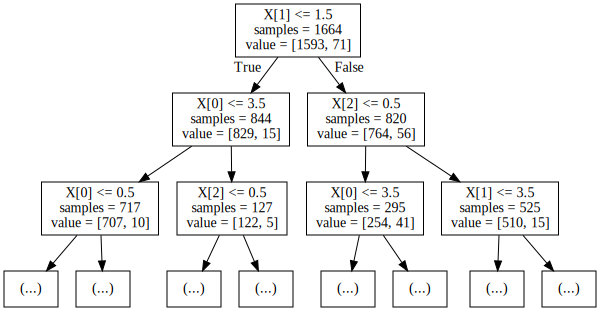

In [145]:
### Graphs

import graphviz
from sklearn.tree import export_graphviz

# Dysplasia
dot_data = export_graphviz(model_dys_training, out_file=None, impurity=False,max_depth=2)
graph_dys = graphviz.Source(dot_data)
graph_dys

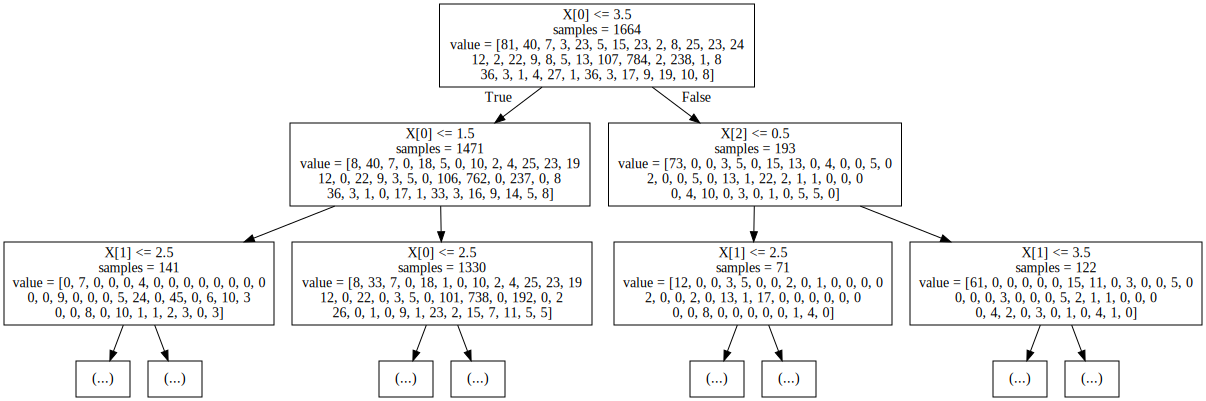

In [146]:
# Diagnosis
dot_data = export_graphviz(model_diag_training, out_file=None, impurity=False,max_depth=2)
graph_diag = graphviz.Source(dot_data)
graph_diag